In [1]:
using PauliPropagation
using Plots

In this example, we will compute the two-point correlation function of an 
observable undergoing a unitary evolution given by the transverse field Ising 
model with a tilted field. 
$$
H = \sum_{(j,\, j+1)} Z_j Z_{j+1} 
  + g_z \sum_{j=1}^{n} Z_j + g_x \sum_{j=1}^{n} X_j.
$$

The unitary for its Trotterized Hamiltonian evolution of $l$-layer with time $\Delta t$
is implemented in `tiltedtfitrottercircuit`.
$$
U(\Delta t) = \prod_{a=1}^{l} \prod_{j=1}^n e^{-i \Delta t g_x   X_j} \prod_{j=1}^{n-1} e^{-i \Delta t g_z  Z_j} e^{-i \Delta t g_z Z_j Z_{j+1}}.
$$

In [12]:
# Define the set of local operators that are part of the Hamiltonian
"""
    function tiltedtfi_local_ham_pauli(
        nq::Int,
        gx::Float64,
        gz::Float64,
        topology=nothing,
        site=nothing, 
    )

Construct local energy operator for the tilted transverse field Ising model.

# Arguments
- `nq::Int`: The number of qubits in the system.
- `gx::Float64`: The transverse field strength.
- `gz::Float64`: The longitudinal field strength.
- `topology=nothing`: Circuit topology used to construct the local energy operator.
- `site=nothing`: The site at which to construct the local energy operator.

# Returns
- `PauliSum`: The local energy operator.
"""
function tiltedtfi_local_ham_pauli(
    nq::Int,
    gx::Float64,
    gz::Float64,
    topology=nothing,
    site=nothing, 
)
    if isnothing(site)
        if nq % 2 == 0
            site = Int(nq / 2)
        else
            site = Int((nq + 1) / 2)
        end
    else
        site = site
    end
    
    # check if the site is in the topology
    if topology != nothing
        max_site = maximum(Iterators.flatten(topology))
        if site ∉ Iterators.flatten(topology)
          throw(ArgumentError("Site $site is not in the topology."))
        end

        # check that number of qubits 
        if nq != max_site
          throw(ArgumentError(
              "The number of qubits $nq is not equal to the \
              maximum index $max_site in the topology."
          ))
        end
    else
        topology = [(ii, ii + 1) for ii in 1:nq-1]
    end

    # Build local energy operator
    local_energy = PauliSum(nq, PauliString(nq, :X, site, gx))
    add!(local_energy, :Z, site, gz)

    terms_site = Base.filter(x -> site in x, topology)
    for pair in terms_site
        # coefficient is split as 1 / number of terms
        add!(local_energy, [:Z, :Z], pair, 0.5)
    end

    return local_energy
end

# define evolution angles for TTFI model
"""
Compute the evolution angles for the tiltied transverse field Ising model.
"""

function thetas_ttfi(circuit; deltat=1., J=1, gz=0.9045, gx=1.4)
    thetas = []

    indices_gate_zz = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    indices_gate_x = getparameterindices(circuit, PauliRotation, [:X])
    indices_gate_z = getparameterindices(circuit, PauliRotation, [:Z])

    for (idx, gate) in enumerate(circuit)

        if idx in indices_gate_zz
            coupling_strength = deltat * J
        elseif idx in indices_gate_x
            coupling_strength = deltat * gx
        elseif idx in indices_gate_z
            coupling_strength = deltat * gz
        else
            throw(ArgumentError("Gate at index $idx is neither ZZ, X nor Z rotation"))
        end
        push!(thetas, coupling_strength * 2) # e^i t P / 2 * 2
    end
            
    return thetas
end

thetas_ttfi (generic function with 1 method)

In [13]:
# Define time evolution function
"""
Perform Pauli propagation using the merging BFS algorithm.

Args:
    circuit: The circuit to be applied.
    p_init: The operator to be propagated.
    thetas: The angles for the Trotter steps.
    max_weight: The maximal operator weight.
    min_abs_coeff: Neglect small coefficients.


Returns:
    p_propagated: The evolved operator; correlation_matrix: ccorrelation matrix.
"""
function pauli_propagation(
    nq::Int,
    p_init::PauliSum;
    max_weight=Inf,
    min_abs_coeff=0.,
    customtruncationfunction=nothing,
    nl=1,
    deltat=0.25,
    periodic=false,
    circuit = tiltedtfitrottercircuit,
    topology=bricklayertopology,
    gx=1.4,
    gz=0.9045,
)
    circ = circuit(nq, 1; topology=topology(nq, periodic=periodic))
    thetas = thetas_ttfi(circ; deltat=deltat, gx=gx, gz=gz)
    correlation_matrix = zeros(nl + 1, nq)
    init_overlap = zeros(nq)
    fixed_paulis = [
        tiltedtfi_local_ham_pauli(nq, gx, gz, topo, j) for j in 1:nq
    ]
    # Compute the renormalized expectation values for the initial pauli p_init: 
    # Tr[P P_fixed]/ 2^n
    # note this is directly the coefficient of P_fixed.
    for j in 1:nq
        init_overlap[j] = scalarproduct(p_init, fixed_paulis[j])
    end

    norm = sum(init_overlap)
    correlation_matrix[1, :] = init_overlap / norm 
    p_propagated = p_init / norm  # normalize the initial state

    for i in 1:nl
        # Pauli propagation for a single Trotter step
        p_propagated = propagate(
            circ, p_propagated, thetas; max_weight=max_weight, 
            min_abs_coeff=min_abs_coeff,
            customtruncationfunction=customtruncationfunction
        )
        # Compute the local expectation values for p_propagated
        for j in 1:nq
            correlation_matrix[i+1, j] = scalarproduct(
                p_propagated, fixed_paulis[j]
            )
        end
    end

    return p_propagated, correlation_matrix
end

pauli_propagation

### Operator evolution Tilted Transverse Field Ising model (TTFI) (L=9)

Given an initial local Hamiltonian operator `p_init` at site $j$, e.g.
$$
p_{j} = \frac{1}{2} (Z_{j-1}Z_{j} + Z_{j}Z_{j+1}) + g_z Z_j + g_x X_j
$$
Now we compute the evolved operator $p_j(t) = U(t)^\dagger p_j U(t)$ after a depth-$l$ circuit with $t = l\Delta t$. Here $p_j(t)$ is given by `p_propagated`. \
We also compute the `correlation matrix`
$$
M_{ij}(t) = \text{Tr}[p_i(t) p_j].
$$
In particular, in the example code below we compare the correlation matrix for propagation computed from different `truncations` Pauli weights. \
The exact evolution is given by setting the truncation weight to be `Inf`. However, we will see in practice high weight Paulis can be truncated for approximate evolutions.

In [14]:
nq = 9  # number of qubits
nl = 80  # number of layers l
gx = 1.4  # transverse field strength
gz = 0.9045  # longitudinal field strength
deltat = 0.25  # Trotterization time step
periodic = false
truncations = [2, 3, 4, Inf]  # truncation Pauli weights

topo = bricklayertopology(nq, periodic=periodic)
p_init = tiltedtfi_local_ham_pauli(nq, gx, gz, topo)
corr_mats_truncations = Dict()
p_propagated_truncations = Dict()
for max_weight in truncations
    p_propagated, correlation_matrix = pauli_propagation(
        nq, p_init, gx=gx, gz=gz, nl=nl, periodic=periodic, 
        max_weight=max_weight, deltat=deltat
    )
    corr_mats_truncations[max_weight] = correlation_matrix
    p_propagated_truncations[max_weight] = p_propagated
end


We can look at the correlation matrix $M_{5j}(l)$ (here we have set $i=5$). \
Notice that the correlation becomes non-zero for positions that grow linearly with the number of layers (time). The slope is roughly is "butterfly velocity". \
Moreover, the weight of the matrix at the intial site $5$ decreases with time, showing the "spreading" of operators.

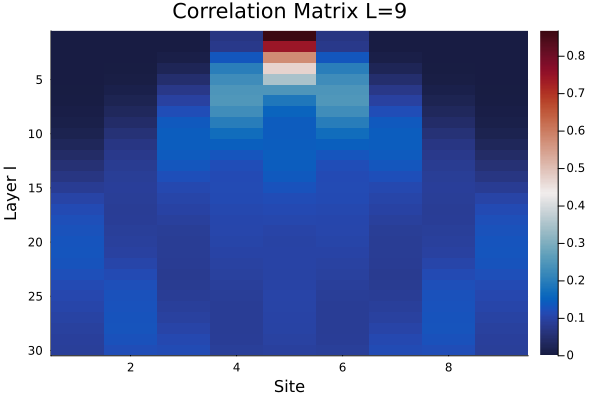

In [15]:
# Let's plot the exact correlation matrix for short times
corrmat_exact = corr_mats_truncations[Inf]
heatmap(corrmat_exact[1:30, 1:end], yflip=true, c=:balance, xlabel="Site", ylabel="Layer l", title="Correlation Matrix L=9")

Now we are ready to extract the `diffusion constant` $D$ of this model. This has been analyzed in Reference [RKF22](https://arxiv.org/abs/2004.05177). \
The diffusion constant is defined via the slope of the `mean-squared displacement` (MSD) $d^2(t)$ as
$$
D = \frac{1}{2} \partial_t d^2(t).
$$

MSD roughly measures how far an operator has traveled to, defined as (see EQ(3) in the paper above)
$$
d^2(t) = (\sum_j C_j(t) j^2) - (\sum_j C_j(t) j)^2,
$$
where $C_j(t) = \text{Tr} [p_{i=5}(t) p_j]$ is the evolved amplitude of the local Hamiltonian operator $p_j$. 

In [16]:

#@title | Some utility functions for extracting diffusion constants

function msd(cor_mat)
    """
    Compute the mean square displacement from correlation matrix.
  
    Args:
        cor_mat: correlation matrix (time, site).
  
    Returns:
        msd: mean square displacement d^2(time).
    """
    nt = size(cor_mat)[1]  # number of time steps
    dsquared = zeros(nt) 
    
    for i in 1:nt
        first_term = 0
        second_term = 0
        for (j, c) in enumerate(cor_mat[i, :])
            first_term += c * j^2 
            second_term += c * j
        end
        dsquared[i] = first_term - second_term^2
    end
    
    return dsquared
  end
  
  """
  function to perform linear regression using the closed-form solution
  """
  function linear_regression(x, y)
    # Create the design matrix with a column of ones (for intercept) and x values
    X = [ones(length(x)) x]
    
    # Compute the least squares solution
    intercept, slope = X \ y  # This solves (X'X) \ (X'y), returning [intercept, slope]
  
    return slope, intercept
  end
  
  """
  function to fit the mean square displacement
  """
  function fit_msd(msd_result, fit_range, deltat)
    fit_time = collect(fit_range) * deltat
    slope, intercept = linear_regression(fit_time, msd_result[fit_range])
    fitted_line = slope * collect(fit_time) .+ intercept
    return slope, intercept, fitted_line
  end
  
  """
  Postprocessing fitted lines for the mean square displacement.
  
  Args:
      corr_mats_truncations (Dict(Vector)): correlation matrices for different truncations.
      truncations (Vector): truncation values.
      fit_range (UnitRange): range of time steps to fit the mean square displacement.
      deltat (Float): time step.
  
  Returns:
      fitted_lines (Dict(Vector)): fitted lines for the mean square displacement.
      slopes (Dict(Float)): slopes of the fitted lines.
  """
  function collect_fitted_lines(corr_mats_truncations, truncations, fit_range, deltat)
      fitted_lines = Dict()
      slopes = Dict()
      for max_weight in truncations
          msd_result = msd(corr_mats_truncations[max_weight][2:end, :])
          slope, intercept, fitted_line = fit_msd(msd_result, fit_range, deltat);
          fitted_lines[max_weight] = fitted_line
          slopes[max_weight] = slope
      end
      return fitted_lines, slopes
  end

collect_fitted_lines

Using the utility functions to compute the mean-sqaured displacement (MSD) $d^2(t)$, we fit the MSD to extract the diffusion constant $D$. \
Moreover, we compare the MSDs extracted using Pauli Propagation with various truncation weights $l^* = 2, 3, 4$ as well as MSD from the exact evolution $l^* = \infty$. \
We see that the evolution quickly converges with finite truncation weight. Our results here reproduce Fig.2(b) for $L=9$ in [RKF22](https://arxiv.org/abs/2004.05177).

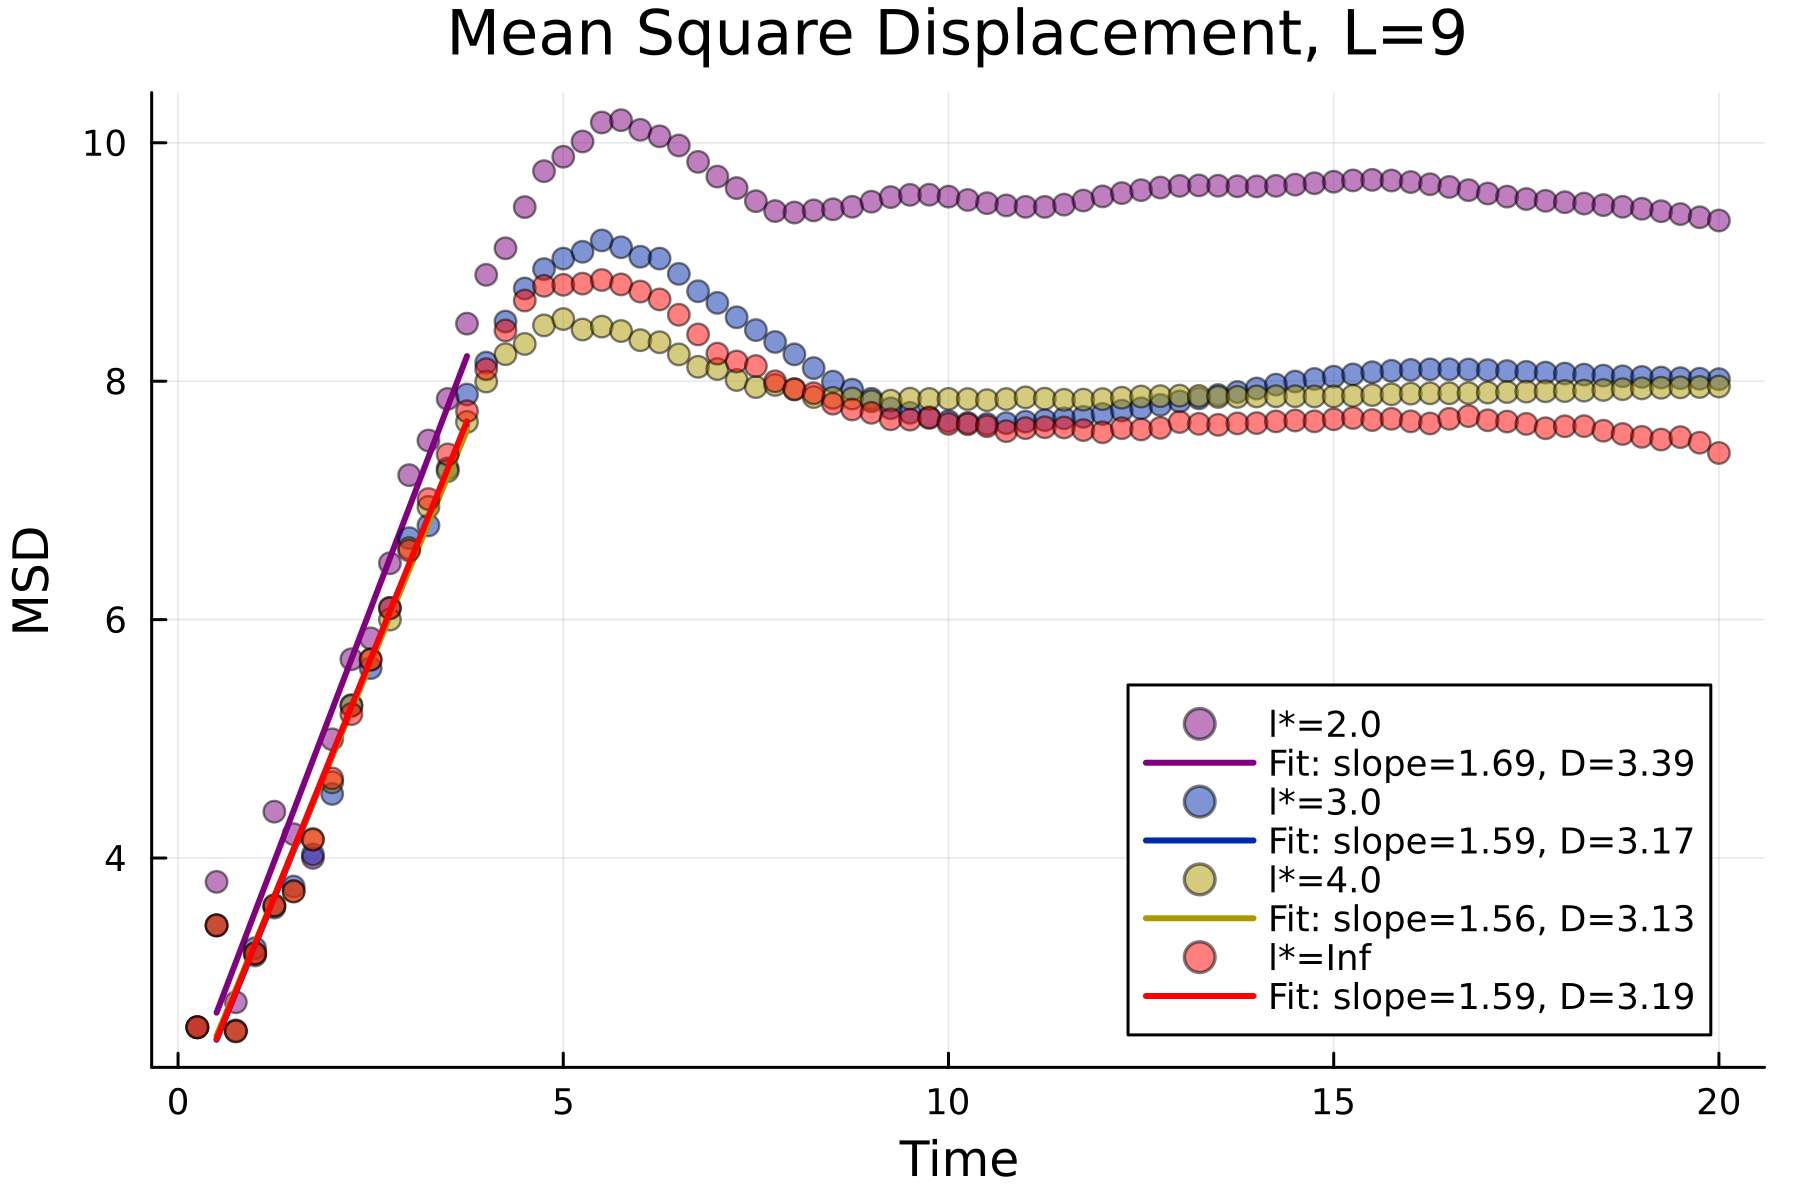

In [17]:
fit_range = 2:15
fitted_lines, slopes = collect_fitted_lines(corr_mats_truncations, truncations, fit_range, deltat)
dpi = 300
Plot = plot()

colors = palette(:rainbow, length(truncations))
plot_truncations = truncations
for (i, max_weight) in enumerate(plot_truncations)
    msd_result = msd(corr_mats_truncations[max_weight][2:end, :])
    time = collect(1:nl) * deltat
    fit_time = collect(fit_range) * deltat
    slope = slopes[max_weight]
    fitted_line = fitted_lines[max_weight]
    scatter!(
        Plot, time, msd_result, label="l*=$max_weight", xlabel="Time", ylabel="MSD", 
        dpi=dpi, markercolor=colors[i], alpha=0.5, markershape=:circle,
    )
    plot!(Plot, fit_time, fitted_lines[max_weight], lw=2, color=colors[i],
        label="Fit: slope=$(round(slope, digits=2)), D=$(round(slope*2, digits=2))", 
        title="Mean Square Displacement, L=$nq", legend=:bottomright)
end

display(Plot)